# Domácí úloha 2 - Typová analýza

## Importy knihoven a definice pomocných funkcí

Následující buňky je potřeba spustit, aby vše fungovalo, jak má

In [2]:
import graphviz as gv
import nltk
import nltk.sem.logic as lg

In [3]:
def construct_tree(expression: nltk.sem.Expression, is_lambda: bool = False, variable: lg.Variable = None):
    """Funkce, která výstup NLTK převede do stromové struktury.
    Funkce prozatím nepokrývá veškeré možnosti výstupu NLTK,
    pro naši potřebu je ale postačující.
    """
    tree = {"node": str(expression), "type": expression.type}

    if isinstance(expression, lg.ApplicationExpression):
        if (not is_lambda) or (not isinstance(expression.argument, lg.IndividualVariableExpression)):
            tree["children"] = [
                construct_tree(expression.function, is_lambda, variable),
                construct_tree(expression.argument)
            ]
        else:
            tree = {
                "node": str(expression),
                "type": expression.function.type,
                "children": []
            }
    elif isinstance(expression, lg.BinaryExpression):
        if isinstance(expression, lg.AndExpression):
            operand = "AND"
        elif isinstance(expression, lg.OrExpression):
            operand = "OR"
        elif isinstance(expression, lg.ImpExpression):
            operand = "=>"
        elif isinstance(expression, lg.IffExpression):
            operand = "<=>"
        if not is_lambda:
            tree["children"] = [
                construct_tree(expression.first),
                {"node": f"{operand} {expression.second}", "type": "<t,t>", "children": [{"node": operand, "type": "<t,<t,t>>"}, construct_tree(expression.second)]}
            ]
        else:
            tree["children"] = [
                construct_tree(lg.LambdaExpression(variable, expression.first), True, variable),
                construct_tree(lg.LambdaExpression(variable, expression.second), True, variable)
            ]
    elif isinstance(expression, lg.NegatedExpression):
        if not is_lambda:
            tree["children"] = [
                {"node": "NOT", "type": "<t,t>"},
                construct_tree(expression.term)
            ]
        else:
            child = construct_tree(lg.LambdaExpression(variable, expression.term), True, variable)
            tree = {
                "node": str(expression),
                "type": child["type"],
                "children": [child]
            }
    elif isinstance(expression, lg.LambdaExpression):
        tree["children"] = construct_tree(expression.term, True, expression.variable)["children"]
    return tree

In [4]:
def id_generator():
    """Generátor unikátních ID - jsou níže použita pro jednoznačné identifikování uzlů v grafu
    """
    idx = 0
    while True:
        yield str(idx)
        idx += 1

def generate_graph(graph):
    """Ze stromové struktury vytvořené pomocí construct_tree vykreslí graf
    """
    dot = gv.Digraph(node_attr={"shape": "plaintext"}, edge_attr={"dir": "back"})
    nodeid = id_generator()
    root = next(nodeid)
    dot.node(root, f"{graph['node']}\ntyp: {graph['type']}")

    def add_level(parent, children, digraph, id_gen):
        for child in children:
            node = next(id_gen)
            digraph.node(node, f"{child['node']}\ntyp: {child['type']}")
            digraph.edge(parent, node)
            add_level(node, child.get("children", []), digraph, id_gen)

    add_level(root, graph.get("children", []), dot, nodeid)
    return dot

In [5]:
def type_analysis(expression, signature):
    """Funkce, která na základě zadaného výrazu a přiřazení typů vykreslí strom s typy.
    """
    expr = nltk.sem.Expression.fromstring(expression, signature=signature, type_check=True)
    tree = construct_tree(expr)
    return generate_graph(tree)

## Domácí úloha

Níže máte zadaných 5 vět, na kterých si postupně procvičíte typovou analýzu od nejjednodušších intranzitivních predikátů po predikátovou modifikaci a shifter, který z množiny "vytahuje" konkrétní entitu. Pro každou úroveň úlohy uvádím jeden řešený příklad, na kterém případně vysvětluju některé jevy.

Pro každou úlohu vždy stačí doplnit typy do předpřipraveného "slovníku" (to je taková ta struktura ve složených závorkách).

### Úloha 1 - intranzitivní predikáty

V těchto i dalších úlohách uvažujte vlastní jména jako konkrétní entity.

#### Řešená úloha:

* Věta: Vilda je kocour.
* Přepis: `být_kocour(Vilda)`
* Typy:
    * `být_kocour` - <e,t>
    * `Vilda` - e (jedná se o vlastní jméno)

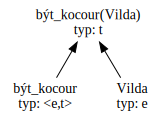

In [6]:
sig = {
    "být_kocour": "<e,t>",
    "Vilda": "e"
}

type_analysis("být_kocour(Vilda)", sig)

#### Zadání:
* Věta: Šípková Růženka spí.
* Přepis: `spát(Šípková_Růženka)`

In [ ]:
sig = {
    "spát": "",
    "Šípková_Růženka": "",
}

type_analysis(r"spát(Šípková_Růženka)", sig)

### Úloha 2 - tranzitivní predikáty

Tranzitivní predikáty jsou ve formulích zapisovány pomocí lambda abstrakce, aby se zajistilo, že ve stromu jako první dojde k saturaci objektem a až následně k saturaci subjektem.

#### Řešená úloha:
* Věta: Vilda kousnul Ferdu.
* Přepis: `\x.kousnout(x, Ferda)(Vilda)`
* Typy:
    * `kousnout` - <e,<e,t>>
    * `Vilda` - e (vlastní jméno)
    * `Ferda` - e

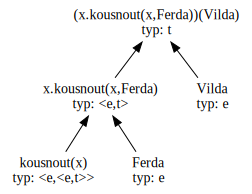

In [7]:
sig = {
    "kousnout": "<e,<e,t>>",
    "Vilda": "e",
    "Ferda": "e"
}

type_analysis(r"\x.kousnout(x, Ferda)(Vilda)", sig)

#### Zadání:
* Věta: Hobbes je Calvinův přítel.
* Přepis: `\x.být_přítel(x, Calvin)(Hobbes)`

In [ ]:
sig = {
    "být_přítel": "",
    "Calvin": "",
    "Hobbes": "",
}

type_analysis(r"\x.být_přítel(x, Calvin)(Hobbes)", sig)

### Úloha 3 - predikátová modifikace

Predikátová modifikace reprezentuje průnik dvou množin. V příkladech níže bude zapisována pomocí lambda abstrakce.

#### Řešená úloha:

* Věta: Petr je chytrý student.
* Formule: `\x.(je_chytrý(x) & je_student(x))(Petr)`
* Typy:
    * `je_chytrý` - <e,t>
    * `je_student` - <e,t>
    * `Petr` - e (vlastní jméno)

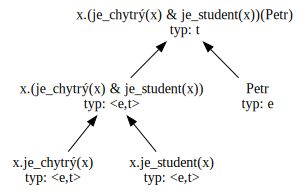

In [8]:
sig = {
    "je_chytrý": "<e,t>",
    "je_student": "<e,t>",
    "Petr": "e"
}

type_analysis(r"\x.(je_chytrý(x) & je_student(x))(Petr)", sig)

#### Zadání:
* Věta: Calvin je malý chlapec.
* Přepis: `\x.(být_malý(x) & být_chlapec(x))(Calvin)`

In [ ]:
sig = {
    "být_malý": "",
    "být_chlapec": "",
    "Calvin": "",
}

type_analysis(r"\x.(být_malý(x) & být_chlapec(x))(Calvin)", sig)

### Úloha 4 - "určitý člen"

Tato sekce je určena k procvičení něčeho, co by se dalo považovat za určitý člen (v češtině nevyřčený), který z množiny entit "získá" jednu konkrétní entitu. V příkladech se bude jednat o funkce `ten`, `ta`, `to`, případně `ty`.

(Alternativním řešením by bylo použití existenčního kvantifikátoru, o tom ale možná někdy jindy).

Množiny entit jsou v přepisu pomocí formulí reprezentovány pomocí lambda funkcí, jejichž argumenty nejsou saturovány.

#### Řešená úloha
* Věta: Masaryk nosí čepici.
* Přepis: `\x.nosit(x, ta(\y.čepice(y)))(Masaryk)`
* Typy:
    * `nosit` - <e,<e,t>>
    * `ta` - <<e,t>,e> ("určitý člen," který z množinu entit získá konkrétní entitu)
    * `čepice` - <e,t>
    * `Masaryk` - e

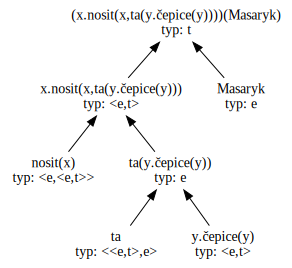

In [9]:
sig = {
    "nosit": "<e,<e,t>>",
    "ta": "<<e,t>,e>",
    "čepice": "<e,t>",
    "Masaryk": "e"
}

type_analysis(r"\x.nosit(x, ta(\y.čepice(y)))(Masaryk)", sig)

#### Zadání:
* Věta: Rob Kterýten ukradl ovci.
* Přepis: `\x.ukrást(x, ta(\y.ovce(y)))(Rob_Kterýten)`

In [ ]:
sig = {
    "ukrást": "",
    "ta": "",
    "ovce": "",
    "Rob_Kterýten": "",
}

type_analysis(r"\x.ukrást(x, ta(\y.ovce(y)))(Rob_Kterýten)", sig)

### Úloha 5 - predikátová modifikace dohromady s "určitým členem"

Tato úloha využívá všechny poznatky, které jste nabyli v úlohách předchozích. Věřím proto, že i bez řešené úlohy se zvládnete poprat se zadáním.

#### Zadání:
* Věta: Paul Atreides jezdí na písečném červu.
* Přepis: `\x.jezdit_na(x, ten(\y.(písečný(y) & červ(y))))(Paul_Atreides)`

In [ ]:
sig = {
    "jezdit_na": "",
    "ten": "",
    "písečný": "",
    "červ": "",
    "Paul_Atreides": "",
}

type_analysis(r"\x.jezdit_na(x, ten(\y.(písečný(y) & červ(y))))(Paul_Atreides)", sig)